## import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

use the sklearn library to implement machine learning models and process data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

some models may be used

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC

## import data

In [4]:
data = pd.read_csv("C:/Users/helen/HP/adult21.csv")
selected = pd.read_excel("C:/Users/helen/HP/selected.xlsx")#手动筛选后的变量，删除部分显然的无意义变量
m_df = pd.read_excel("C:/Users/helen/HP/selectedformyself.xlsx",usecols=[0,1])#m_df包括各变量含义
m_df.set_index('variables',inplace = True)

In [5]:
s_list = selected.values.tolist()
s_list = list(np.ravel(s_list))
df = pd.DataFrame()#df是仅包含筛选后变量的数据集
for i in s_list:
    df = pd.concat([df,data.loc[:,i]],axis=1)

In [6]:
#删除所有观测值相同的变量
for i in s_list:
    uni = np.unique(df[i])
    if len(uni)==1:
        df = df.drop(i)

# data anaysis

## replace abnormal value with na

In [7]:
out99 = ['LSATIS11R_A','PLNWRKR1_A','EDUCP_A','MAXEDUCP_A','AGEP_A']

In [8]:
df99 = df[out99]
WTFA = df['WTFA_A']
df9 = df.drop(columns=out99)
df9 = df9.drop(columns='WTFA_A')

In [9]:
df9 = df9.replace({7.0: np.nan, 8.0: np.nan, 9.0: np.nan})  #these values means refuse to answer, Not Ascertained and don't know
df99 = df99.replace({97.0: np.nan, 98.0: np.nan, 99.0: np.nan})  
df = pd.concat([df9,df99,WTFA],axis=1)

## handling missing values

In [10]:
df = df.dropna(thresh=125)
#Delete rows with a null value> 10%

In [11]:
#checking percent of null in columns
nullcolumns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
nullcolumns = nullcolumns.drop(nullcolumns[nullcolumns.null == 0].index)#无空值的列不参与计算
nullcolumns

,null
PLNWRKR1_A,32.21
JOBCHGEARN_A,27.72
EMPSICKLV_A,27.68
CLSWRKNOS1_A,27.59
EMDWRKCAT1_A,27.57
...,...
DEMENEV_A,0.01
COGMEMDFF_A,0.01
SOCERRNDS_A,0.01
PAIFRQ3M_A,0.01


In [12]:
col = df.columns.tolist()

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")#众数填充
for i in col:
    df[[i]]=imputer.fit_transform(df[[i]])

In [14]:
print(np.any(df.isnull())) # 只要有一个空值便会返回True，否则返回False

False


Hence, there is no problem with null values in the entire dataset.

## understanding the data

### Checking the distribution of disease

Description    冠心病
Name: CHDEV_A, dtype: object
2.0    21007
1.0     1265
Name: CHDEV_A, dtype: int64
percent of disease sample is 0.06 



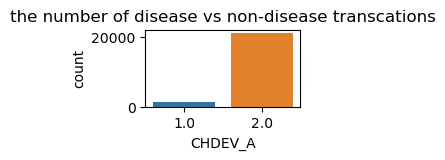

Description    心脏病
Name: MIEV_A, dtype: object
2.0    21516
1.0      756
Name: MIEV_A, dtype: int64
percent of disease sample is 0.03 



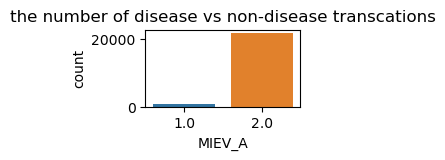

Description    中风
Name: STREV_A, dtype: object
2.0    21611
1.0      661
Name: STREV_A, dtype: int64
percent of disease sample is 0.03 



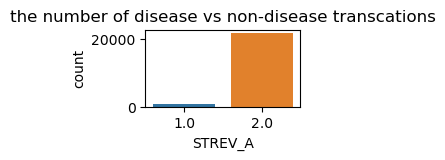

Description    癌症
Name: CANEV_A, dtype: object
2.0    19470
1.0     2802
Name: CANEV_A, dtype: int64
percent of disease sample is 0.13 



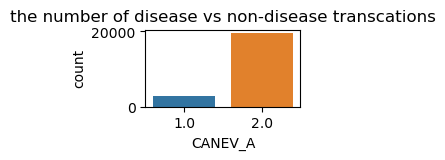

Description    痴呆症
Name: DEMENEV_A, dtype: object
2.0    22077
1.0      195
Name: DEMENEV_A, dtype: int64
percent of disease sample is 0.01 



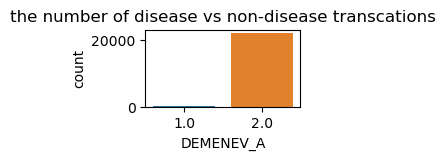

Description    虚弱/衰竭的肾脏
Name: KIDWEAKEV_A, dtype: object
2.0    21605
1.0      667
Name: KIDWEAKEV_A, dtype: int64
percent of disease sample is 0.03 



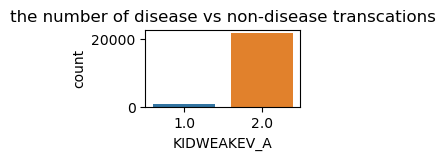

Description    肝硬化/肝病
Name: LIVEREV_A, dtype: object
2.0    22055
1.0      217
Name: LIVEREV_A, dtype: int64
percent of disease sample is 0.01 



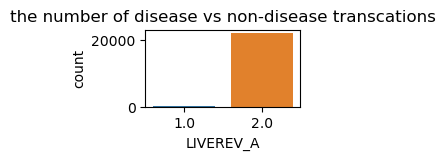

In [15]:
disease = ['CHDEV_A','MIEV_A','STREV_A','CANEV_A','DEMENEV_A','KIDWEAKEV_A','LIVEREV_A']
for i in disease:
    classes = df[i].value_counts()
    disease_share = round((classes[1]/df[i].count()),2)
    print(m_df.loc[i])
    print(classes)
    print('percent of disease sample is',disease_share,'\n')
    # Bar plot for the number of disease vs non-disease transcations
    rcParams['figure.figsize'] = 2, 1
    sns.countplot(x=i, data=df)
    plt.title('the number of disease vs non-disease transcations')
    plt.show()

We need to take care of the data imbalance later

### take a look at the histograms for each features

In [16]:
features = set(s_list) - set(disease)

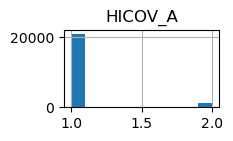

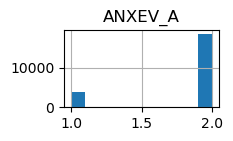

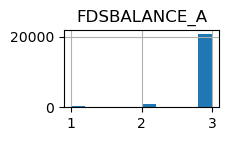

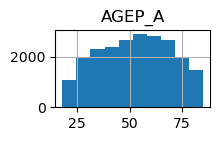

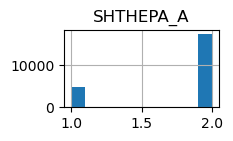

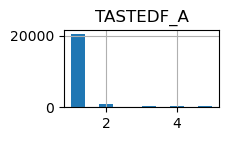

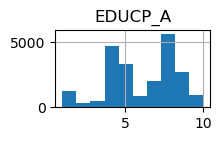

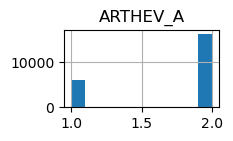

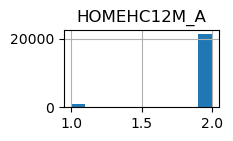

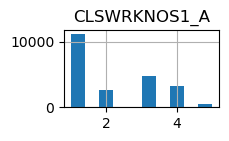

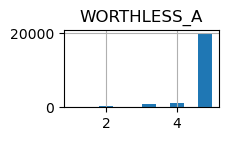

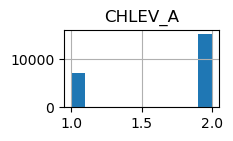

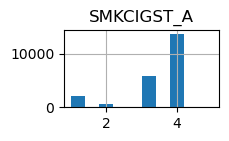

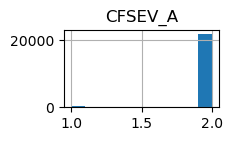

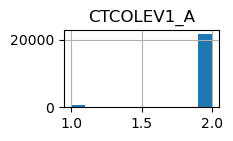

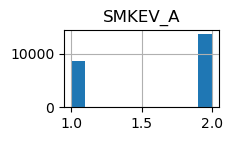

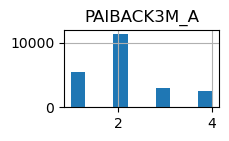

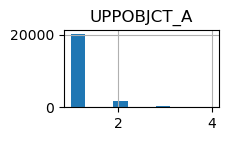

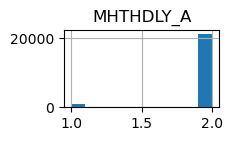

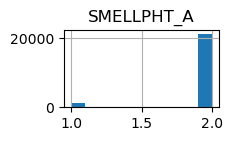

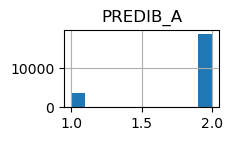

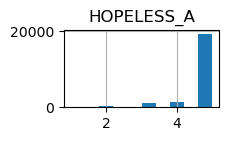

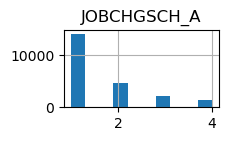

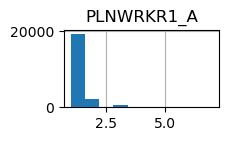

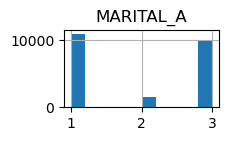

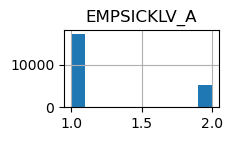

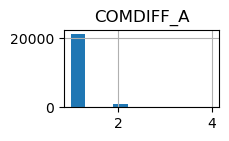

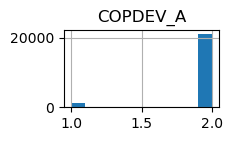

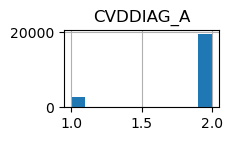

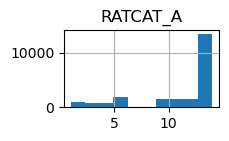

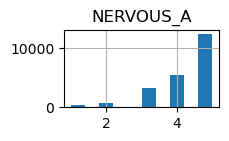

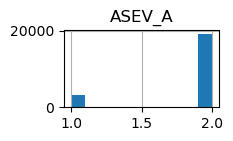

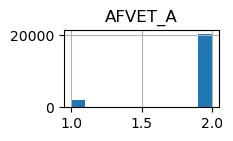

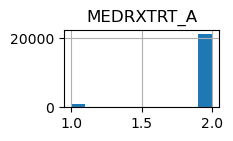

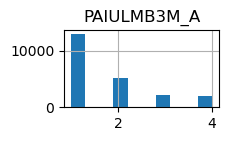

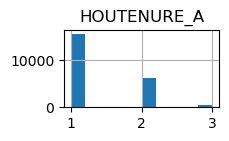

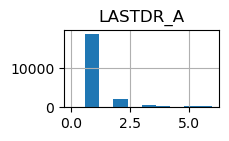

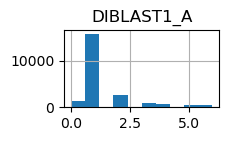

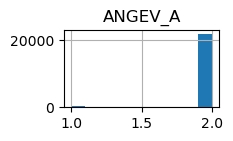

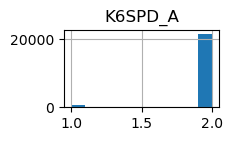

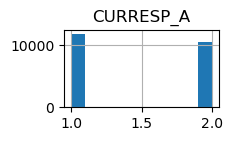

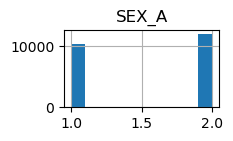

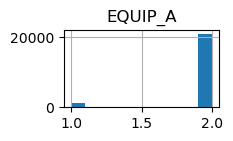

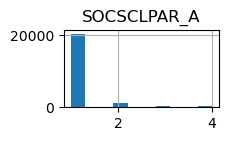

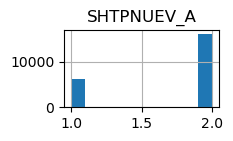

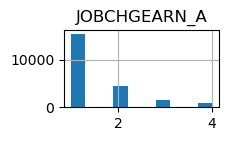

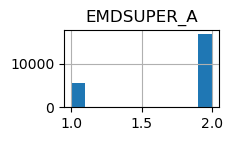

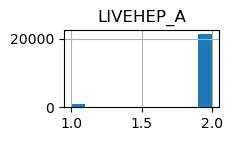

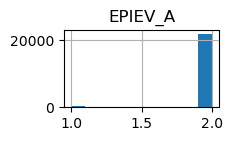

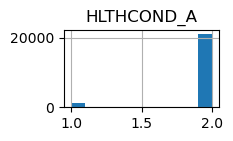

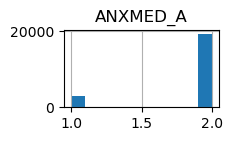

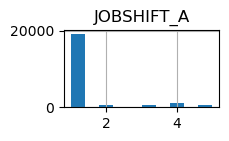

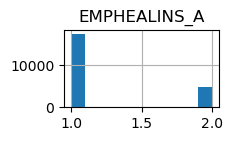

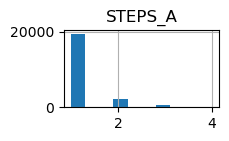

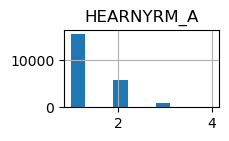

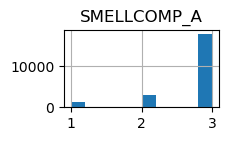

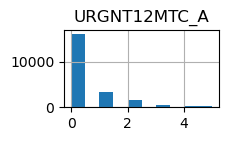

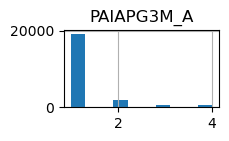

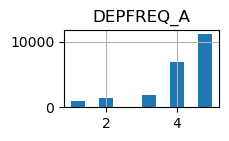

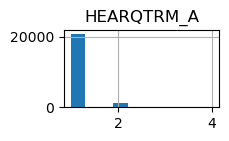

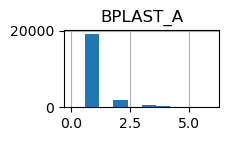

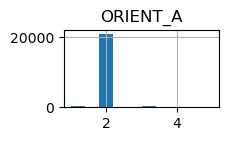

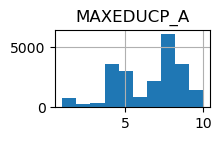

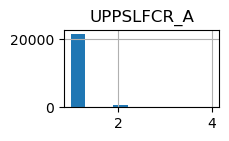

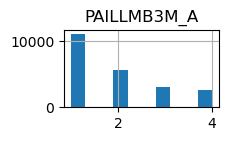

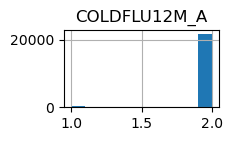

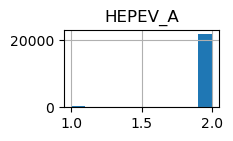

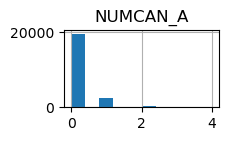

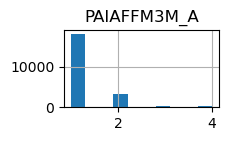

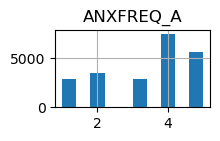

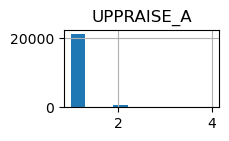

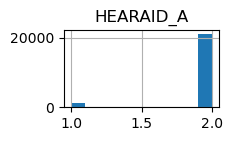

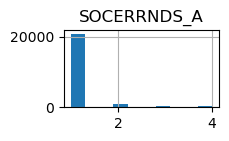

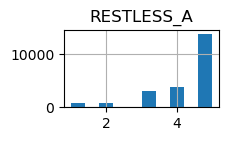

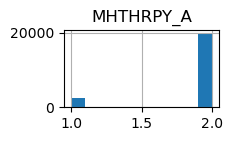

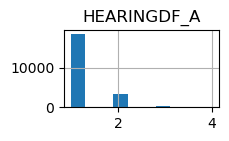

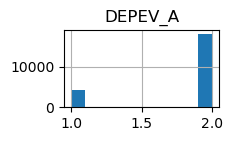

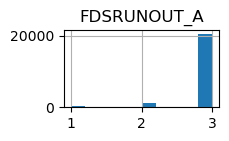

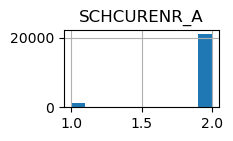

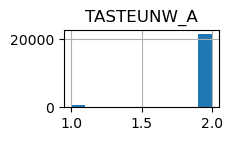

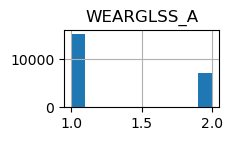

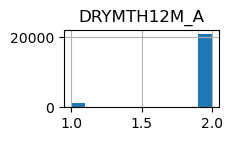

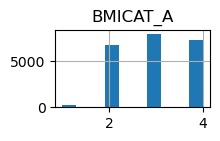

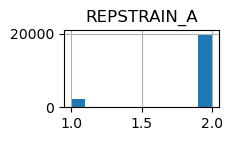

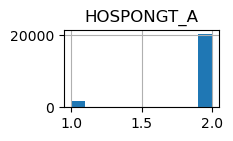

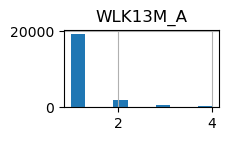

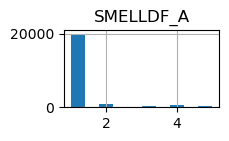

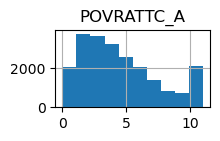

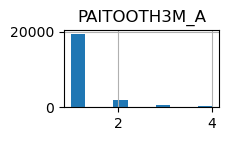

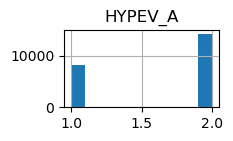

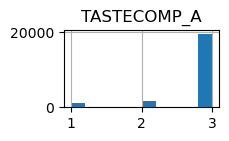

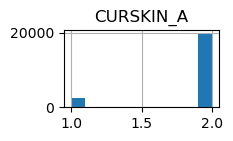

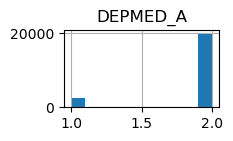

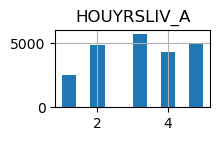

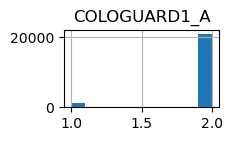

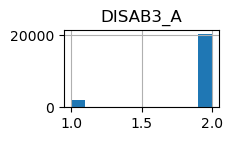

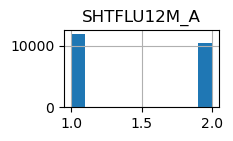

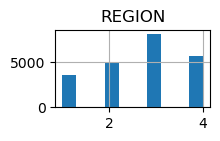

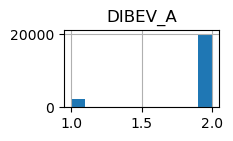

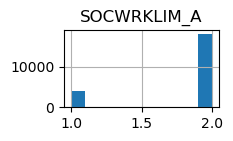

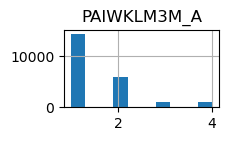

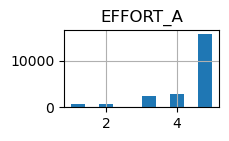

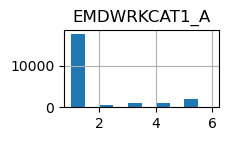

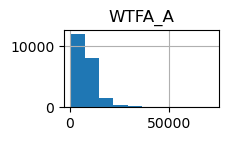

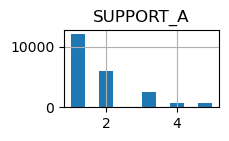

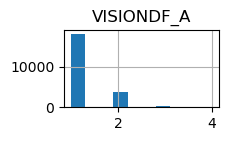

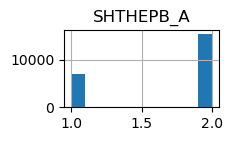

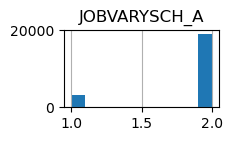

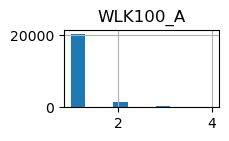

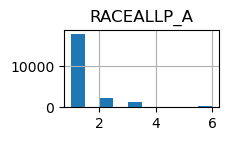

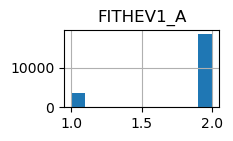

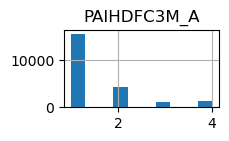

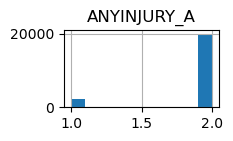

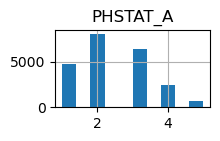

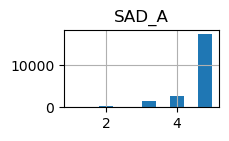

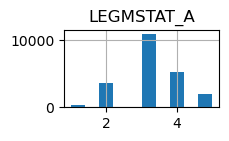

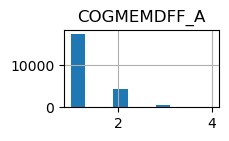

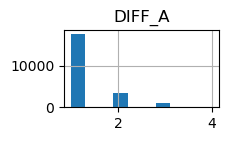

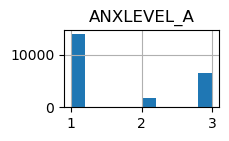

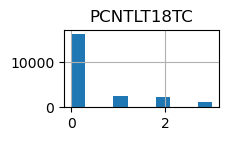

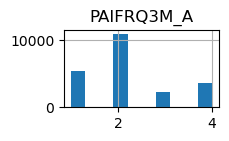

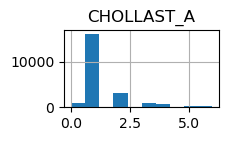

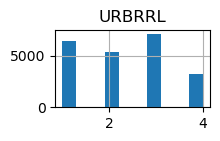

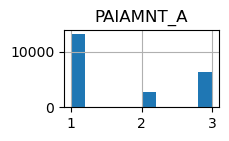

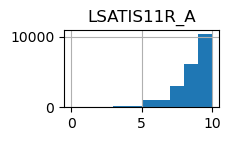

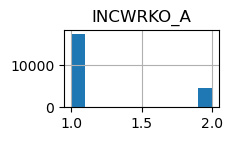

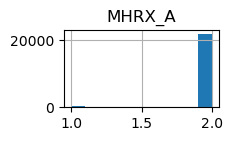

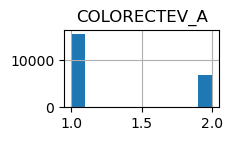

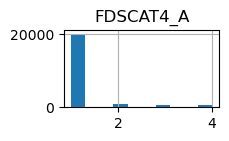

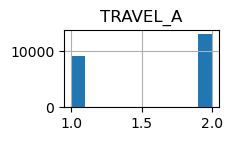

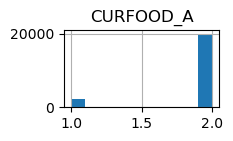

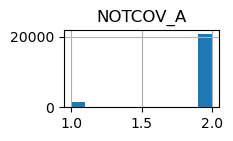

In [17]:
for i in features:
    rcParams['figure.figsize'] = 2, 1
    df.loc[:,[i]].hist()

### split dataset into labels and features datasets.

In [18]:
y = df[disease]
X = df[features]

### some categorial variables need to be converted into dummy variables. And then scale the dataset

In [19]:
y = y.replace(2,0)  

In [20]:
cate_v = []
con_v = []
for i in features:
    uni = np.unique(X.loc[:,[i]])
    if len(uni)<20:
        cate_v.append(i)
    else:
        con_v.append(i)
X = pd.get_dummies(X,columns = cate_v)
standardScaler = StandardScaler()
X[con_v] = standardScaler.fit_transform(X[con_v])

## model

### train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

### Metric selection for heavily imbalanced data

As the data is heavily imbalanced, Accuracy is not a good measure for evaluating the model. Because regardless of any prediction model, the model will get 90+% accuracy.

Hence, the ROC-AUC score will be used for fair evaluation of the model.After determining the optimal threshold, we can calculate the F1 score of the classifier to measure the precision and recall at the selected threshold.

### Random Forest Classifier

First consider using randomforest. Because Random forests can be used to rank the importance of variables in a regression or classification problem in a natural way.

##### model

In [23]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [24]:
disease_col = list(y_train.columns)

In [25]:
forest = RandomForestClassifier(n_estimators = 500, max_depth = 20, max_features = 'auto',bootstrap = True, random_state = 18)

In [26]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

CHDEV_A
Sensitivity:  0.057692307692307696
Specificity:  0.999761620977354
F1-Score:  0.10869565217391304


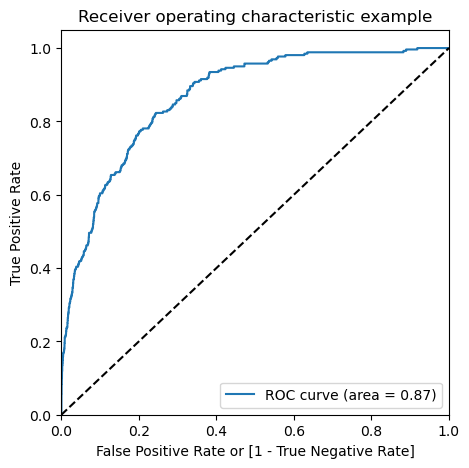

MIEV_A
Sensitivity:  0.0
Specificity:  1.0
F1-Score:  0.0


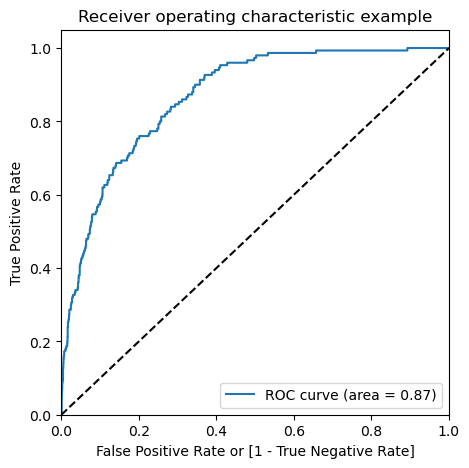

STREV_A
Sensitivity:  0.0
Specificity:  1.0
F1-Score:  0.0


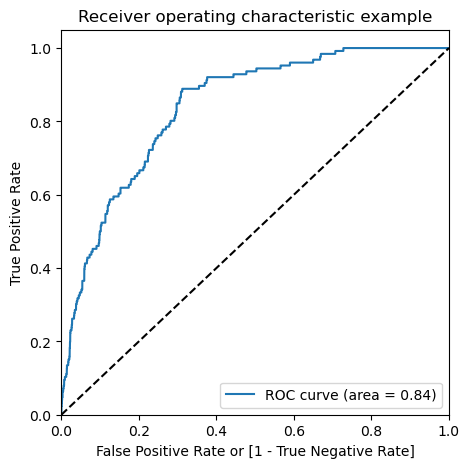

CANEV_A
Sensitivity:  1.0
Specificity:  1.0
F1-Score:  1.0


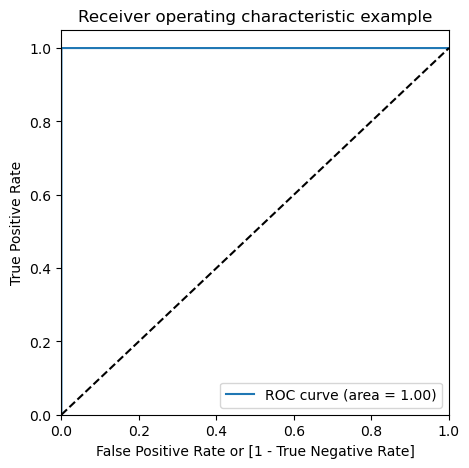

DEMENEV_A
Sensitivity:  0.0
Specificity:  1.0
F1-Score:  0.0


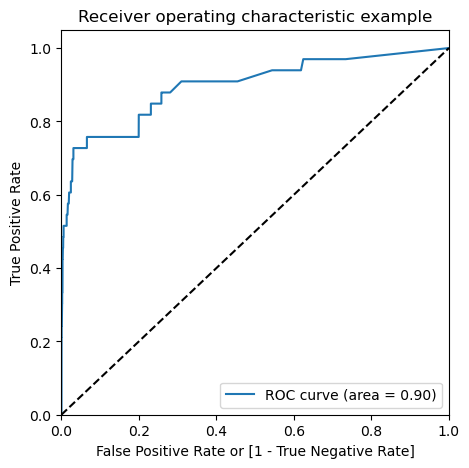

KIDWEAKEV_A
Sensitivity:  0.0
Specificity:  1.0
F1-Score:  0.0


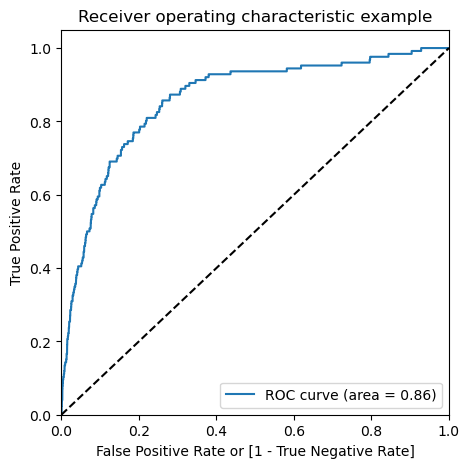

LIVEREV_A
Sensitivity:  0.0
Specificity:  1.0
F1-Score:  0.0


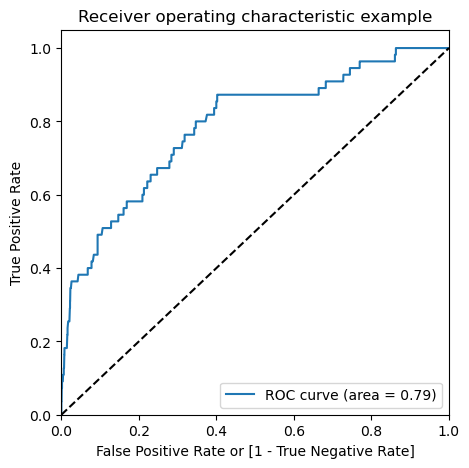

In [27]:
for i in disease_col:
    print(i)
    y_tra = y_train[i]
    clf = forest.fit(X_train,y_tra)#model fitting
    y_te_pred = clf.predict(X_test)#prediction on the test set
    y_te = y_test[i]
    #confusion matrix
    confusion = metrics.confusion_matrix(y_te, y_te_pred)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    print("Sensitivity: ",TP / float(TP+FN))
    print("Specificity: ", TN / float(TN+FP))
    print("F1-Score: ", f1_score(y_te, y_te_pred))
    #ROC on the test set
    y_test_pred_proba = clf.predict_proba(X_test)[:,1]#predicted probability
    draw_roc(y_te, y_test_pred_proba)#plot the ROC curve

##### Feature Importance

be continued...